In [1]:
import json
import os
import pandas as pd
from scipy import stats

In [2]:
nodes = ["start", "count", "gccount1", "gccount2", "atcount1", "atcount2", "gcsum", "atsum", "gcratio"]

base_dir = "/home/ubuntu/projects/causality-fbp/scipipe-demo/"

# concatenator breaks the audit log: https://github.com/scipipe/scipipe/issues/127
# so we need to trace audit up to concatenator
# as well as each audit files leading up to concatenator
# annoying, but alas!
audit_files = ["gcratio.txt.audit.json",
               "chry.fa.gccnt1.audit.json", "chry.fa.gccnt2.audit.json",
               "chry.fa.atcnt1.audit.json", "chry.fa.atcnt2.audit.json"]

n_repeats = 20
n_records = 30


In [54]:
def normalize_df(df):
    normalized_df=(df-df.min())/(df.max()-df.min())
    # normalized_df=(df-df.mean())/df.std()
    return normalized_df

def load_dataset(mode, repeat_id):
    if mode not in ['normal', 'break_count', 'break_start']:
        raise ValueError(f'Wrong mode {mode} given')
    
    if repeat_id < 1 or repeat_id > n_repeats:
        raise ValueError(f'Wrong repeat id {repeat_id} given')

    experiment_dir = os.path.join(base_dir, 'experiment', mode, f'repeat_{repeat_id}')    
    all_records = []

    for i in range(1, n_records+1):
        raw_data = {}
        for final_audit_file in audit_files:
            with open(os.path.join(experiment_dir, str(i), final_audit_file)) as f:
                audit_data = json.load(f)
            
            audit_data_queue = [audit_data]
            while audit_data_queue:
                audit_data = audit_data_queue.pop(0)
                if audit_data["ProcessName"] in nodes:
                    # we assume all our nodes output exactly one file
                    # Big Assumption!
                    data_file_name = next(iter(audit_data["OutFiles"].values()))
                    with open(os.path.join(experiment_dir, str(i), data_file_name)) as data_file:
                        line = data_file.readline()

                    # calc may output tilde for division
                    # so we need to remove it, plus any whitespaces
                    value = float(line.strip().strip('~'))
                    raw_data[audit_data["ProcessName"]] = value
                
                for upstream_data in audit_data["Upstream"].values():
                    if upstream_data:
                        audit_data_queue.append(upstream_data)
        
        all_records.append(raw_data)

    return pd.DataFrame(all_records)


In [55]:
import networkx as nx, numpy as np, pandas as pd
from dowhy import gcm

In [56]:
causal_graph = nx.DiGraph([
    ('count', 'gccount1'),
    ('count', 'gccount2'),
    ('count', 'atcount1'),
    ('count', 'atcount2'),
    ('start', 'gccount1'),
    ('start', 'gccount2'),
    ('start', 'atcount1'),
    ('start', 'atcount2'),

    ('gccount1', 'gcsum'),
    ('atcount1', 'atsum'),
    ('gccount2', 'gcsum'),
    ('atcount2', 'atsum'),

    ('gcsum', 'gcratio'),
    ('atsum', 'gcratio'),
])

In [68]:
def compute_attributions(break_mode):
    attributions_per_experiment = []
    for i in range(1, n_repeats+1):
        normal_df = load_dataset('normal', i)
        break_df = load_dataset(break_mode, i)

        causal_model = gcm.ProbabilisticCausalModel(causal_graph)
        causal_model.set_causal_mechanism('count', gcm.EmpiricalDistribution())
        causal_model.set_causal_mechanism('start', gcm.EmpiricalDistribution())
        causal_model.set_causal_mechanism('gccount1', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
        causal_model.set_causal_mechanism('gccount2', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
        causal_model.set_causal_mechanism('atcount1', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
        causal_model.set_causal_mechanism('atcount2', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
        causal_model.set_causal_mechanism('gcsum', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
        causal_model.set_causal_mechanism('atsum', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
        causal_model.set_causal_mechanism('gcratio', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))

        attributions = gcm.distribution_change(causal_model, normal_df, break_df, 'gcratio')
        attributions_per_experiment.append(attributions)
    
    return pd.DataFrame(attributions_per_experiment)

In [69]:
break_count_attr_df = compute_attributions('break_count')

/home/ubuntu/projects/causality-fbp/.venv/lib/python3.10/site-packages/dowhy/gcm/distribution_change.py:231: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  joint_data = old_data.append(new_data, ignore_index=True, sort=True)
Estimating Shapley Values. Average change of Shapley values in run 9 (45 evaluated permutations): -57.151732233043006%: 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]
/home/ubuntu/projects/causality-fbp/.venv/lib/python3.10/site-packages/dowhy/gcm/distribution_change.py:231: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  joint_data = old_data.append(new_data, ignore_index=True, sort=True)
Estimating Shapley Values. Average change of Shapley values in run 14 (70 evaluated permutations): -14.855801932281102%: 100%|██████████| 1/1 [00:01<00:00,  1.43s/it]
/home/ubuntu/projects/causality-fbp/.venv

In [82]:
break_count_attr_df = break_count_attr_df.abs()
break_count_attr_df

,atcount1,atcount2,atsum,count,gccount1,gccount2,gcratio,gcsum,start
0,0.015598,0.319924,0.004685,0.094402,0.086363,0.048978,0.000534,0.005521,0.006255
1,0.081803,0.166649,0.024705,1.155210,0.112690,0.090589,0.193129,0.044917,0.009869
2,0.069006,0.483680,0.008226,0.550130,0.100132,0.111084,0.139393,0.018232,0.000329
3,0.012987,0.243377,0.010132,1.261359,0.155459,0.196279,0.001138,0.026472,0.026514
4,0.242867,0.455469,0.009954,0.112675,0.314109,0.050375,0.123452,0.000527,0.008782
5,0.482646,0.561672,0.001010,0.350354,0.013874,0.044212,0.126305,0.003960,0.011165
6,0.045372,0.099094,0.015565,0.567982,0.505911,0.007480,0.133821,0.016174,0.007372
7,0.052785,0.377109,0.005069,0.199340,0.260587,0.067626,0.001429,0.010045,0.009515
8,0.036668,0.171864,0.006002,0.341761,0.187575,0.103969,0.000281,0.005656,0.015817
9,0.160633,0.336250,0.011298,0.553487,0.192931,0.119926,0.001907,0.011234,0.015921


In [83]:
for column in nodes:
    if column == "count":
        continue
    
    test_result = stats.ttest_ind(break_count_attr_df["count"].to_list(),
                                  break_count_attr_df[column].to_list(),
                                  equal_var=False)
    
    print(f"{column}: p-value = {test_result.pvalue}")



start: p-value = 9.463323733647683e-06
gccount1: p-value = 0.0009027312437099204
gccount2: p-value = 3.846458458730368e-05
atcount1: p-value = 9.915585096925865e-05
atcount2: p-value = 0.0034163043211717843
gcsum: p-value = 9.511324941771921e-06
atsum: p-value = 9.077502267317253e-06
gcratio: p-value = 2.258119538603662e-05


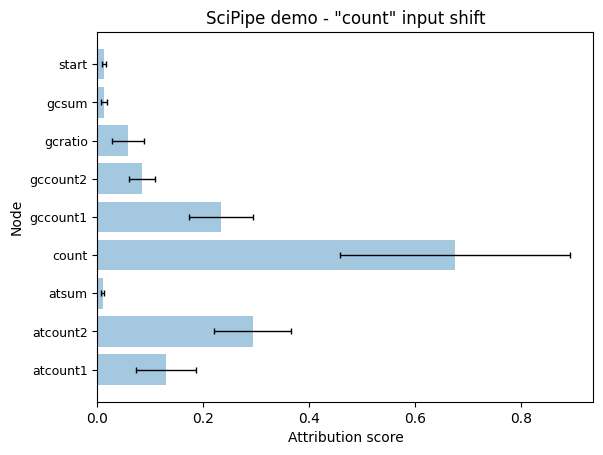

In [126]:
import math
records_count = break_count_attr_df.shape[0]
records_means = break_count_attr_df.mean(axis=0).to_list()
std = break_count_attr_df.std(axis=0).to_list()
columns = break_count_attr_df.columns.to_list()

ci95_lower = []
ci95_range = []
for m, s in zip(records_means, std):
    lower = m - 1.96*s/math.sqrt(records_count)
    ci95_lower.append(lower)
    ci95_range.append(m - lower)


import matplotlib.pyplot as plt

plt.barh(range(len(records_means)), records_means, xerr=ci95_range, alpha=0.4, align='center', error_kw={'capsize':2, 'elinewidth':1})
plt.yticks(range(len(records_means)), columns)
# plt.xscale('log')
plt.xlabel('Attribution score')
plt.ylabel('Node')
plt.yticks(fontsize=9)
# plt.xscale('symlog', base=10)
# plt.xticks([0, 0.1])
plt.axvline(0, color='black', alpha=0.7, linestyle='dotted')
plt.title('SciPipe demo - "count" input shift')

plt.savefig("scipipe-count.pdf", bbox_inches='tight')
plt.show()

In [111]:
break_start_attr_df = compute_attributions('break_start')

/home/ubuntu/projects/causality-fbp/.venv/lib/python3.10/site-packages/dowhy/gcm/distribution_change.py:231: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  joint_data = old_data.append(new_data, ignore_index=True, sort=True)
Estimating Shapley Values. Average change of Shapley values in run 14 (70 evaluated permutations): -17.45484420656583%: 100%|██████████| 1/1 [00:01<00:00,  1.50s/it]
/home/ubuntu/projects/causality-fbp/.venv/lib/python3.10/site-packages/dowhy/gcm/distribution_change.py:231: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  joint_data = old_data.append(new_data, ignore_index=True, sort=True)
Estimating Shapley Values. Average change of Shapley values in run 15 (75 evaluated permutations): -11.429088235811733%: 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]
/home/ubuntu/projects/causality-fbp/.venv

In [115]:
break_start_attr_df = break_start_attr_df.abs()
break_start_attr_df

,atcount1,atcount2,atsum,count,gccount1,gccount2,gcratio,gcsum,start
0,0.001196,0.005121,0.015879,0.019224,0.006466,0.005117,1.896295,0.005794,0.605200
1,1.104919,1.468684,0.001429,0.001520,0.224906,0.002695,1.820869,0.001313,1.484073
2,2.354022,0.005746,0.015211,0.002734,0.012495,0.015599,2.029403,0.010181,1.811333
3,1.305126,0.346692,0.007758,0.019431,0.430884,0.001373,1.876832,0.013346,1.380703
4,0.018709,0.007989,0.021656,0.005297,0.011496,0.013681,1.839660,0.002051,0.440211
5,0.499682,0.524235,0.011933,0.038472,0.156852,0.161469,3.337876,0.020247,0.557825
6,0.003991,0.004686,0.000747,0.015008,0.022434,0.001723,2.144036,0.002499,0.872128
7,0.007902,0.002614,0.006619,0.008923,0.003128,0.002519,1.705523,0.011438,0.353061
8,0.002361,0.006379,0.002717,0.002104,0.019456,0.005783,1.881684,0.009506,0.717989
9,0.017356,0.000179,0.024746,0.014277,0.009458,0.010832,1.906327,0.008004,0.669346


In [122]:
for column in nodes:
    if column == "start":
        continue
    
    test_result = stats.ttest_ind(break_start_attr_df["start"].to_list(),
                                  break_start_attr_df[column].to_list(),
                                  equal_var=False)
    
    print(f"{column}: p-value = {test_result.pvalue}")



count: p-value = 3.681909367343092e-07
gccount1: p-value = 4.477140754913696e-06
gccount2: p-value = 5.500643236925509e-07
atcount1: p-value = 1.5361391259523974e-06
atcount2: p-value = 0.00046666214987497995
gcsum: p-value = 3.5133110921742506e-07
atsum: p-value = 3.5573992262813906e-07
gcratio: p-value = 9.962420056311161e-06


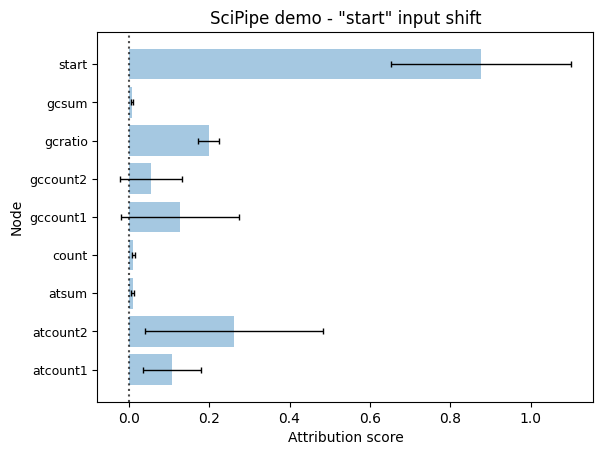

In [127]:
import math
records_count = break_start_attr_df.shape[0]
records_means = break_start_attr_df.mean(axis=0).to_list()
std = break_start_attr_df.std(axis=0).to_list()
columns = break_start_attr_df.columns.to_list()

ci95_lower = []
ci95_range = []
for m, s in zip(records_means, std):
    lower = m - 1.96*s/math.sqrt(records_count)
    ci95_lower.append(lower)
    ci95_range.append(m - lower)


import matplotlib.pyplot as plt

plt.barh(range(len(records_means)), records_means, xerr=ci95_range, alpha=0.4, align='center', error_kw={'capsize':2, 'elinewidth':1})
plt.yticks(range(len(records_means)), columns)
# plt.xscale('log')
plt.xlabel('Attribution score')
plt.ylabel('Node')
plt.yticks(fontsize=9)
# plt.xscale('symlog', base=10)
# plt.xticks([0, 0.1])
plt.axvline(0, color='black', alpha=0.7, linestyle='dotted')
plt.title('SciPipe demo - "start" input shift')

plt.savefig("scipipe-start.pdf", bbox_inches='tight')
plt.show()

In [44]:
df = load_dataset('break_start', 1)
df

,gcratio,atsum,gcsum,gccount1,count,start,gccount2,atcount1,atcount2
0,0.401522,708.0,475.0,339.0,52.0,180.0,136.0,550.0,158.0
1,0.397930,640.0,423.0,316.0,56.0,181.0,107.0,513.0,127.0
2,0.397930,640.0,423.0,316.0,92.0,181.0,107.0,513.0,127.0
3,0.397930,640.0,423.0,316.0,84.0,181.0,107.0,513.0,127.0
4,0.376910,367.0,222.0,222.0,68.0,185.0,0.0,367.0,0.0
5,0.376910,367.0,222.0,222.0,88.0,185.0,0.0,367.0,0.0
6,0.382746,508.0,315.0,267.0,88.0,183.0,48.0,442.0,66.0
7,0.382746,508.0,315.0,267.0,90.0,183.0,48.0,442.0,66.0
8,0.382746,508.0,315.0,267.0,51.0,183.0,48.0,442.0,66.0
9,0.393425,572.0,371.0,292.0,81.0,182.0,79.0,477.0,95.0


In [37]:
df = load_dataset('normal', 1)
df

,gcratio,atsum,gcsum,gccount1,count,start,gccount2,atcount1,atcount2
0,0.406410,3704.0,2536.0,1204.0,51.0,105.0,1332.0,1916.0,1788.0
1,0.410170,5765.0,4009.0,1971.0,84.0,107.0,2038.0,3129.0,2636.0
2,0.410952,4948.0,3452.0,1638.0,69.0,98.0,1814.0,2562.0,2386.0
3,0.410311,4175.0,2905.0,1380.0,58.0,94.0,1525.0,2160.0,2015.0
4,0.405556,3852.0,2628.0,1249.0,53.0,105.0,1379.0,1991.0,1861.0
5,0.411071,4947.0,3453.0,1634.0,69.0,93.0,1819.0,2566.0,2381.0
6,0.408021,5683.0,3917.0,1863.0,79.0,93.0,2054.0,2937.0,2746.0
7,0.408874,5462.0,3778.0,1799.0,76.0,100.0,1979.0,2821.0,2641.0
8,0.407564,4621.0,3179.0,1507.0,64.0,105.0,1672.0,2393.0,2228.0
9,0.407671,6316.0,4347.0,2175.0,95.0,101.0,2172.0,3454.0,2862.0


In [21]:
normal_df = load_dataset('normal', 3)
break_start_df = load_dataset('break_start', 3)
attributions = gcm.distribution_change(causal_model, normal_df, break_start_df, 'gcratio')

Estimating Shapley Values. Average change of Shapley values in run 20 (100 evaluated permutations): -9.473660227904112%: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


In [22]:
attributions

{'atcount1': -0.005556603389351271,
 'atcount2': -0.0015950600008409722,
 'atsum': 0.0007885089332568149,
 'count': 0.0053672867997377385,
 'gccount1': 0.9083775155448677,
 'gccount2': 0.8845490696216372,
 'gcratio': -0.004472339636299566,
 'gcsum': 0.007280188158339058,
 'start': 1.6299997378532998}

In [5]:
# concatenator breaks the audit log: https://github.com/scipipe/scipipe/issues/127
# so we need to trace audit up to concatenator
# as well as each audit files leading up to concatenator
# annoying, but alas!
audit_files = ["gcratio.txt.audit.json",
               "chry.fa.gccnt1.audit.json", "chry.fa.gccnt2.audit.json",
               "chry.fa.atcnt1.audit.json", "chry.fa.atcnt2.audit.json"]

raw_data = {}
for final_audit_file in audit_files:
    with open(os.path.join(base_dir, "test", final_audit_file)) as f:
        audit_data = json.load(f)
    
    audit_data_queue = [audit_data]
    while audit_data_queue:
        audit_data = audit_data_queue.pop(0)
        if audit_data["ProcessName"] in nodes:
            # we assume all our nodes output exactly one file
            # Big Assumption!
            data_file_name = next(iter(audit_data["OutFiles"].values()))
            with open(os.path.join(base_dir, "test", data_file_name)) as data_file:
                line = data_file.readline()

            # calc may output tilde for division
            # so we need to remove it, plus any whitespaces
            value = float(line.strip().strip('~'))
            raw_data[audit_data["ProcessName"]] = value
        
        for upstream_data in audit_data["Upstream"].values():
            if upstream_data:
                audit_data_queue.append(upstream_data)


In [6]:
raw_data

{'gcratio': 0.3908614575625491,
 'atsum': 9056162.0,
 'gcsum': 5811001.0,
 'gccount1': 5811001.0,
 'count': 300000.0,
 'start': 1.0,
 'gccount2': 0.0,
 'atcount1': 9056162.0,
 'atcount2': 0.0}

In [7]:
all_records = []

for i in range(1, 21):
    raw_data = {}
    for final_audit_file in audit_files:
        with open(os.path.join(base_dir, "test1", str(i), final_audit_file)) as f:
            audit_data = json.load(f)
        
        audit_data_queue = [audit_data]
        while audit_data_queue:
            audit_data = audit_data_queue.pop(0)
            if audit_data["ProcessName"] in nodes:
                # we assume all our nodes output exactly one file
                # Big Assumption!
                data_file_name = next(iter(audit_data["OutFiles"].values()))
                with open(os.path.join(base_dir, "test1", str(i), data_file_name)) as data_file:
                    line = data_file.readline()

                # calc may output tilde for division
                # so we need to remove it, plus any whitespaces
                value = float(line.strip().strip('~'))
                raw_data[audit_data["ProcessName"]] = value
            
            for upstream_data in audit_data["Upstream"].values():
                if upstream_data:
                    audit_data_queue.append(upstream_data)
    
    all_records.append(raw_data)

df = pd.DataFrame(all_records)


In [8]:
# break start
df

,gcratio,atsum,gcsum,gccount1,count,start,gccount2,atcount1,atcount2
0,0.401522,708.0,475.0,339.0,81.0,180.0,136.0,550.0,158.0
1,0.401522,708.0,475.0,339.0,67.0,180.0,136.0,550.0,158.0
2,0.383795,289.0,180.0,180.0,64.0,187.0,0.0,289.0,0.0
3,0.387543,177.0,112.0,112.0,51.0,190.0,0.0,177.0,0.0
4,0.376956,438.0,265.0,243.0,92.0,184.0,22.0,406.0,32.0
5,0.382746,508.0,315.0,267.0,52.0,183.0,48.0,442.0,66.0
6,0.391198,249.0,160.0,160.0,67.0,188.0,0.0,249.0,0.0
7,0.383795,289.0,180.0,180.0,72.0,187.0,0.0,289.0,0.0
8,0.382746,508.0,315.0,267.0,50.0,183.0,48.0,442.0,66.0
9,0.393425,572.0,371.0,292.0,85.0,182.0,79.0,477.0,95.0


In [9]:
# break count
df

,gcratio,atsum,gcsum,gccount1,count,start,gccount2,atcount1,atcount2
0,0.401522,708.0,475.0,339.0,81.0,180.0,136.0,550.0,158.0
1,0.401522,708.0,475.0,339.0,67.0,180.0,136.0,550.0,158.0
2,0.383795,289.0,180.0,180.0,64.0,187.0,0.0,289.0,0.0
3,0.387543,177.0,112.0,112.0,51.0,190.0,0.0,177.0,0.0
4,0.376956,438.0,265.0,243.0,92.0,184.0,22.0,406.0,32.0
5,0.382746,508.0,315.0,267.0,52.0,183.0,48.0,442.0,66.0
6,0.391198,249.0,160.0,160.0,67.0,188.0,0.0,249.0,0.0
7,0.383795,289.0,180.0,180.0,72.0,187.0,0.0,289.0,0.0
8,0.382746,508.0,315.0,267.0,50.0,183.0,48.0,442.0,66.0
9,0.393425,572.0,371.0,292.0,85.0,182.0,79.0,477.0,95.0


In [10]:
# normal
df

,gcratio,atsum,gcsum,gccount1,count,start,gccount2,atcount1,atcount2
0,0.401522,708.0,475.0,339.0,81.0,180.0,136.0,550.0,158.0
1,0.401522,708.0,475.0,339.0,67.0,180.0,136.0,550.0,158.0
2,0.383795,289.0,180.0,180.0,64.0,187.0,0.0,289.0,0.0
3,0.387543,177.0,112.0,112.0,51.0,190.0,0.0,177.0,0.0
4,0.376956,438.0,265.0,243.0,92.0,184.0,22.0,406.0,32.0
5,0.382746,508.0,315.0,267.0,52.0,183.0,48.0,442.0,66.0
6,0.391198,249.0,160.0,160.0,67.0,188.0,0.0,249.0,0.0
7,0.383795,289.0,180.0,180.0,72.0,187.0,0.0,289.0,0.0
8,0.382746,508.0,315.0,267.0,50.0,183.0,48.0,442.0,66.0
9,0.393425,572.0,371.0,292.0,85.0,182.0,79.0,477.0,95.0
